In [1]:
from nldg.utils import *
from nldg.ss import *

NAME_SS = "WORME-SS"

## WORME Smoothing Splines

In [14]:
dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

In [15]:
# instead of cv=True, you can set lam=0.15 (or whatever reasonable value)
erm_ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [16]:
fitted_erm = erm_ss.predict(Xtr)
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 26.006892490403246
Environment 1 MSE: 9.364641820658832
Environment 2 MSE: 5.031164932106395


np.float64(26.006892490403246)

In [17]:
worme_ss = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, solver="ECOS")
preds_worme = worme_ss.predict(x_grid)

In [18]:
fitted_worme = worme_ss.predict(Xtr)
max_mse(Ytr, fitted_worme, Etr, verbose=True)

Environment 0 MSE: 16.26239424327372
Environment 1 MSE: 16.262453748415997
Environment 2 MSE: 11.264905905696539


np.float64(16.262453748415997)

In [19]:
magging_ss = MaggingSmoothSpline()
fitted_magging = magging_ss.fit(Xtr, Ytr, Etr)
preds_magging = magging_ss.predict(x_grid)
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 33.71738617454062
Environment 1 MSE: 5.7017737671921545
Environment 2 MSE: 2.264451214902736


np.float64(33.71738617454062)

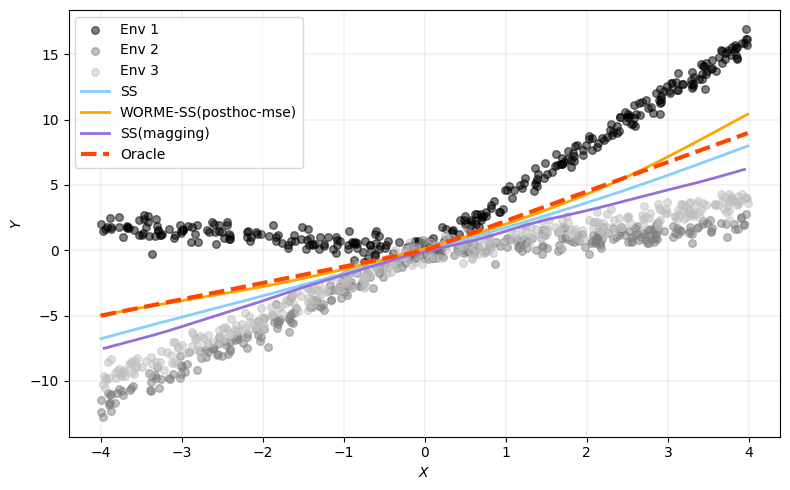

In [20]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_worme, preds_magging=preds_magging,
            optfun=4, saveplot=True, nameplot="setting9_ss")

In [21]:
dtr = gen_data_v7(n=1500, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

In [22]:
erm_ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [23]:
fitted_erm = erm_ss.predict(Xtr)
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 0.6229839404804562
Environment 1 MSE: 1.011168044708953
Environment 2 MSE: 0.19913292989675438


np.float64(1.011168044708953)

In [24]:
worme_ss = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True)
preds_worme = worme_ss.predict(x_grid)

In [25]:
fitted_worme = worme_ss.predict(Xtr)
max_mse(Ytr, fitted_worme, Etr, verbose=True)

Environment 0 MSE: 0.7765476987135226
Environment 1 MSE: 0.776549704556439
Environment 2 MSE: 0.39948200329142475


np.float64(0.776549704556439)

In [26]:
magging_ss = MaggingSmoothSpline()
fitted_magging = magging_ss.fit(Xtr, Ytr, Etr)
preds_magging = magging_ss.predict(x_grid)
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 0.35084015776044275
Environment 1 MSE: 1.3864969516327479
Environment 2 MSE: 0.3107998113728735


np.float64(1.3864969516327479)

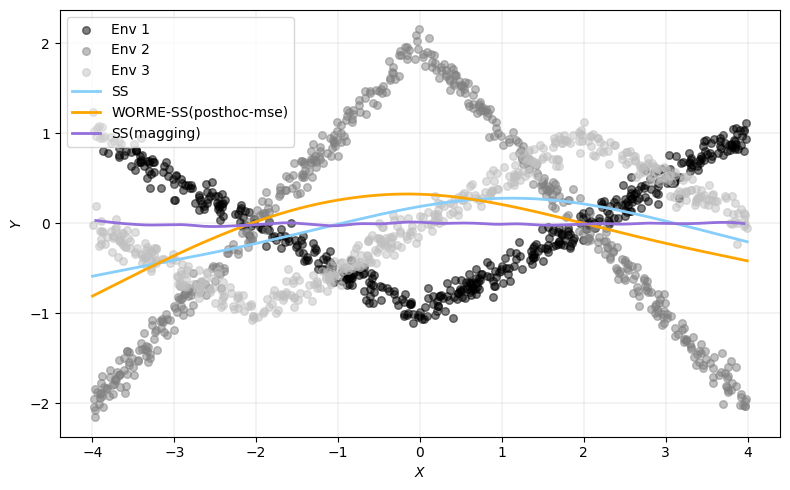

In [27]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_worme, preds_magging=preds_magging,
            saveplot=True, nameplot="setting6_ss")

## Different Objectives

In [2]:
demean_setting = 1
dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2)

Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

if demean_setting == 1:
    Ytr = Ytr_orig
    demean = False
elif demean_setting == 2:
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])
        demean = True

# Fit standard SS for each environment separately.
# This is used for the regret
sols_erm = np.zeros(Etr.shape[0])
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    ss_e = MinMaxSmoothSpline(X_e, Y_e, cv=True, method="erm")
    fitted_e = ss_e.predict(X_e)
    sols_erm[mask] = fitted_e

#### Standard SS

In [3]:
ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_ss = ss.predict(x_grid)
fitted_ss = ss.predict(Xtr)

mse_ss, _ = max_mse(Ytr, fitted_ss, Etr, ret_ind=True)
rw_ss, _ = min_reward(Ytr, fitted_ss, Etr, ret_ind=True)
regret_ss, _ = max_regret(Ytr, fitted_ss, sols_erm, Etr, ret_ind=True)

#### MSE

In [4]:
ss_mse = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="mse")
preds_mse = ss_mse.predict(x_grid)
fitted_mse = ss_mse.predict(Xtr)

mse_mse, _ = max_mse(Ytr, fitted_mse, Etr, ret_ind=True)
rw_mse, _ = min_reward(Ytr, fitted_mse, Etr, ret_ind=True)
regret_mse, _ = max_regret(Ytr, fitted_mse, sols_erm, Etr, ret_ind=True)

### Reward

In [5]:
ss_rw = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="reward")
preds_rw = ss_rw.predict(x_grid)
fitted_rw = ss_rw.predict(Xtr)

mse_rw, _ = max_mse(Ytr, fitted_rw, Etr, ret_ind=True)
rw_rw, _ = min_reward(Ytr, fitted_rw, Etr, ret_ind=True)
regret_rw, _ = max_regret(Ytr, fitted_rw, sols_erm, Etr, ret_ind=True)

#### Regret

In [6]:
ss_regret = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True,
                                method="regret", sols_erm=sols_erm)
preds_regret = ss_regret.predict(x_grid)
fitted_regret = ss_regret.predict(Xtr)

mse_regret, _ = max_mse(Ytr, fitted_regret, Etr, ret_ind=True)
rw_regret, _ = min_reward(Ytr, fitted_regret, Etr, ret_ind=True)
regret_regret, _ = max_regret(Ytr, fitted_regret, sols_erm, Etr, ret_ind=True)

#### SS - magging

In [7]:
ss_magging = MaggingSmoothSpline()
fitted_magging = ss_magging.fit(Xtr, Ytr, Etr)
preds_magging = ss_magging.predict(x_grid)

mse_magging, _ = max_mse(Ytr, fitted_magging, Etr, ret_ind=True)
rw_magging, _ = min_reward(Ytr, fitted_magging, Etr, ret_ind=True)
regret_magging, _ = max_regret(Ytr, fitted_magging, sols_erm, Etr, ret_ind=True)

#### Comparison

In [8]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Reward", "Regret"], ["0", "1"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_ss + rw_ss + regret_ss],
    [round(float(x), 3) for x in mse_mse + rw_mse + regret_mse],
    [round(float(x), 3) for x in mse_rw + rw_rw + regret_rw],
    [round(float(x), 3) for x in mse_regret + rw_regret + regret_regret],
    [round(float(x), 3) for x in mse_magging + rw_magging + regret_magging],
]
df = pd.DataFrame(
    data,
    index=
    [
        "SS",
        f"{NAME_SS}(posthoc-mse)",
        f"{NAME_SS}(posthoc-nrw)",
        f"{NAME_SS}(posthoc-reg)",
        "SS(magging)"
    ],
    columns=cols)
print(df)

Metric                   MSE         Reward         Regret        
Env                        0       1      0       1      0       1
SS                     0.427  17.727  1.190  13.467  0.165  13.402
WORME-SS(posthoc-mse)  6.702   6.702 -5.084  24.492  6.439   2.377
WORME-SS(posthoc-nrw)  0.264  20.820  1.354  10.374  0.001  16.496
WORME-SS(posthoc-reg)  4.417   8.479 -2.799  22.715  4.154   4.154
SS(magging)            0.263  20.840  1.355  10.354  0.000  16.515


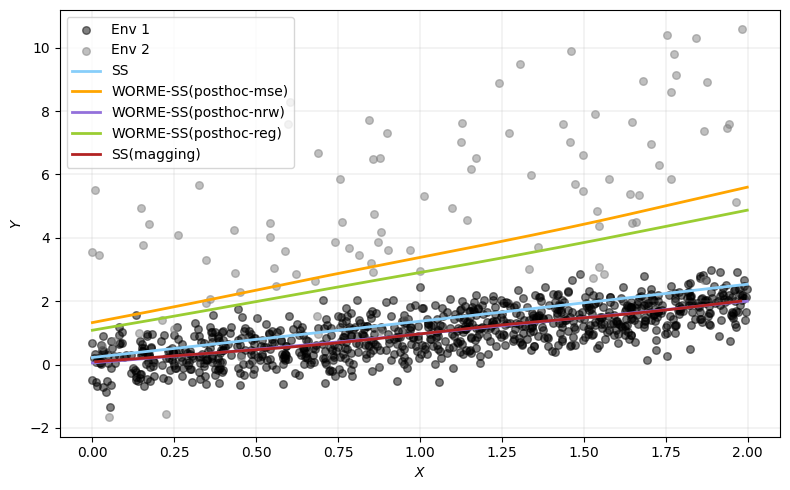

In [9]:
plot_dtr_ss(dtr, x_grid, preds_ss, preds_mse,
            preds_nrw=preds_rw, preds_regret=preds_regret,
            preds_magging=preds_magging, obj_comparison=True,
            saveplot=True, nameplot="setting8_objectives_ss")